# Case Study on Tweets from Ostrava

This notebook demonstrates how the proposed framework can be used in real world. We use tweets published from Ostrava and extract and aggregate sentiment on topics detected in these tweets.

In [1]:
import re

import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
from bertopic import BERTopic
from textblob import TextBlob

/home/milos/.cache/pypoetry/virtualenvs/dissertation-53o3-k0o-py3.11/lib/python3.11/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/milos/.cache/pypoetry/virtualenvs/dissertation-53o3-k0o-py3.11/lib/python3.11/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/h

## Data loading and preprocessing

We start by loading the dataset:

In [2]:
df = pd.read_csv('../datasets/tweets_ostrava_translated.csv', header=None)
df.columns = ['author_id', 'text_orig', 'date_published', 'likes', 'retweets', 'text_en']
df.head()

,author_id,text_orig,date_published,likes,retweets,text_en
0,2765861635,"Bohuzel budou do Tutecka letat dale, jen tank...",2023-03-17 02:58:29+00:00,4,1,"Unfortunately, they will continue to fly to T..."
1,946371211411513346,Já si mohu uložit tvé fotky? Bez svolení? To ...,2023-03-17 00:40:37+00:00,0,0,Can I save your pictures? Without permission?...
2,729345398,"Arsenal-Sporting, 3 hodiny zábavy 👌",2023-03-16 22:47:06+00:00,7,1,"Arsenal-Sporting, 3 hours of fun 👌"
3,864219563172532224,Levice si mne získala již ve velmi útlém věku. ✨,2023-03-16 21:21:56+00:00,31,2,The left won me over at a very young age. ✨
4,917807011152191494,tim jsem byla posedla kdyz mi bylo 11 let,2023-03-16 20:18:15+00:00,7,1,I was obsessed with it when I was 11 years old.


We are only interested in tweets that are not too short:

In [3]:
MIN_TEXT_LENGTH = 60
texts = [t.lower().strip() for t in df['text_en'] if len(str(t)) > 60]
texts[:5]

['unfortunately, they will continue to fly to tuteck, but they will refuel in soci.',
 'can i save your pictures? without permission? is that allowed? 😂😂 only ones you send me directly ☺️',
 "banik's box office fraud is a completely different transfer",
 "where the democrats rule, it looks that way, and it's getting worse.",
 "i'm not saying they shouldn't be paid on time. i'm saying that as long as these people are getting paid, it's wrong, they're doing black things with the benefits... without them, they'd have two choices, they'd either steal or they'd start working properly, that's up to them. that's what the police are there for, to motivate them."]

We perform some basic preprocessing: replacement of contractions and removal of unnecessary characters and of stopwords.

In [4]:
nltk.download('stopwords')
texts_clean = texts

replacements = [
    ("it's", "it is"),
    ("#", ''),
    (r"[^\w\s]", ''),
    (r"\s+", ' '),
    ('dont', 'do not'),
    ('im', 'i am'),
    ('theres', 'there is'),
    ('thats', 'that is'),
    ('youre', 'you are'),
    ('doesnt', 'does not'),
    ('didnt', 'did not'),
    ('cant', 'can not'),
    ('couldnt', 'could not')
]

for replacement in replacements:
    texts_clean = [re.sub(replacement[0], replacement[1], t) for t in texts_clean]

stopwords_en = nltk.corpus.stopwords.words('english')
texts_no_sw = [' '.join([w for w in t.split() if w not in stopwords_en])
               for t in texts_clean if 'holytrainer' not in t]

[nltk_data] Downloading package stopwords to /home/milos/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Topic modeling

Fit the topic model

In [20]:
topic_model = BERTopic(
    language='english', top_n_words=7, n_gram_range=(1, 3),
    min_topic_size=10, nr_topics=50, calculate_probabilities=True, verbose=False)
topic_model.fit(texts_no_sw)

In [6]:
topics = topic_model.get_topics()
topics

{-1: [('like', 0.0059026407428192035),
  ('people', 0.005089888609329631),
  ('would', 0.005060964708850657),
  ('ti', 0.0048349287329656),
  ('one', 0.004592676745420886),
  ('ame', 0.004590980673527276),
  ('know', 0.004513168893765298)],
 0: [('czech', 0.014836946072925117),
  ('ukraine', 0.01410698843760275),
  ('babi', 0.010687682397429423),
  ('russian', 0.009622255828506822),
  ('czech republic', 0.00928193582433962),
  ('republic', 0.009240762634444394),
  ('putin', 0.008370376940609853)],
 1: [('people', 0.010671125954367332),
  ('government', 0.006994220902093067),
  ('communist', 0.006769994990189108),
  ('communists', 0.006214806643926337),
  ('coalition', 0.00604823201731341),
  ('vote', 0.006020516792689907),
  ('ti', 0.005960748871710813)],
 2: [('ostrava', 0.029581563989944812),
  ('brno', 0.008466818181166113),
  ('poruba', 0.008143487562134464),
  ('city', 0.0077390781744536815),
  ('great', 0.006273589606186301),
  ('tram', 0.005745340908648433),
  ('ame', 0.00560450

Next we determine the overall representation of each topic in the dataset:

In [7]:
if -1 in topics:
    del topics[-1]

topic_reprs = topic_model.probabilities_.sum(axis=0)
topic_reprs = {r[0]: r[1] for r in zip(topic_model.get_topics().keys(), topic_reprs)}
topic_reprs

{0: 715.0345288987592,
 1: 621.0363539934831,
 2: 408.18556889466834,
 3: 492.41057916495174,
 4: 370.5362153016027,
 5: 136.82835003727325,
 6: 212.44483874408775,
 7: 159.53481453204404,
 8: 269.93682812896355,
 9: 153.3709964025514,
 10: 210.1979600221459,
 11: 275.6818900061882,
 12: 118.24004167781366,
 13: 137.42978825613267,
 14: 182.62509680063738,
 15: 98.33433809551698,
 16: 138.57235860450052,
 17: 88.9963957365311,
 18: 194.999725602322,
 19: 107.53707269540921,
 20: 162.42068069898724,
 21: 67.25163225685922,
 22: 129.88104533352168,
 23: 107.5004942870943,
 24: 120.61143106551604,
 25: 69.08128517413334,
 26: 67.67720028102848,
 27: 106.53682596076041,
 28: 68.6753561093402,
 29: 69.1364664619613,
 30: 70.39534089211367,
 31: 65.29332715666784,
 32: 68.59872384396736,
 33: 71.65844087639188,
 34: 33.23443293742404,
 35: 33.43121983560827,
 36: 28.08207175863054,
 37: 34.99022216290572,
 38: 34.90706807810892,
 39: 27.16389298415925,
 40: 33.221162126862396,
 41: 30.360069

## Sentiment analysis

When determining polarities we will also deploy a simple masking to ignore tweets whose polarity is very close to 0.

In [8]:
sentiments = []
mask = []

for t in texts:
    if 'holytrainer' in t.lower():
        continue
    polarity = TextBlob(t).sentiment.polarity
    sentiments.append(polarity)
    if abs(polarity) < 0.05:
        mask.append([0] * 49)
    else:
        mask.append([1] * 49)

sentiments = np.array(sentiments).reshape(-1, 1)

Next we calculate mean sentiment for each topic

In [9]:
probas_masked = topic_model.probabilities_ * np.array(mask)
mean_sentiments = (sentiments * probas_masked).sum(axis=0) / probas_masked.sum(axis=0)
mean_sentiments[:5]

array([0.12132554, 0.09851963, 0.13885492, 0.11187013, 0.10306496])

Then we determine the semivariance for both sides:

In [10]:
def semivariance(data, mean: np.ndarray, probas: np.ndarray, side):
    semivariances = []
    for i in range(len(mean)):
        if side == 'left':
            semi_data = data[data < mean[i]]
            semi_probas = probas[(data < mean[i]).reshape(-1), i]
        else:
            semi_data = data[data > mean[i]]
            semi_probas = probas[(data > mean[i]).reshape(-1), i]
        nominator = (((semi_data - mean[i]) ** 2) * semi_probas).sum(axis=0)
        denominator = semi_probas.sum(axis=0)
        result = np.sqrt(nominator / denominator)
        semivariances.append(result)
    return semivariances


semivariance_left = semivariance(sentiments, mean_sentiments, probas_masked, 'left')
semivariance_right = semivariance(sentiments, mean_sentiments, probas_masked, 'right')

semivariance_left[:5], semivariance_right[:5]

([0.35978675016964906,
  0.3447935345668224,
  0.3320064438423676,
  0.31111877985648995,
  0.36148255048198163],
 [0.28541238593274504,
  0.2751611707804927,
  0.2902103706588903,
  0.26650489034130936,
  0.2925351622408936])

# Conformity calculation

In [11]:
def conformity_positive(answer_fuzzy, neg_a, neg_b):
    if answer_fuzzy[1] >= neg_b:
        possibility = 1
    elif answer_fuzzy[2] <= neg_a:
        possibility = 0
    else:
        x = (neg_a * answer_fuzzy[1] - answer_fuzzy[2] * neg_b) / \
            (neg_a - neg_b + answer_fuzzy[1] - answer_fuzzy[2])
        possibility = (x - neg_a) / (neg_b - neg_a)
    return possibility


def conformity_negative(answer_fuzzy, pos_a, pos_b):
    answer_fuzzy_rev = (- answer_fuzzy[2], - answer_fuzzy[1], - answer_fuzzy[0])
    return conformity_positive(answer_fuzzy_rev, pos_b, pos_a)


## Visualization

Each topic gets visualized as a TFN in a plot. Fuzzy sets representing positive and negative opinion are also added. While diplaying the plot, we also create a dataframe for further exploration

TOPIC: ['czech', 'ukraine', 'babi', 'russian', 'czech republic', 'republic', 'putin'], CON.POS.: 0.50, CON.NEG.: 0.51
TOPIC: ['people', 'government', 'communist', 'communists', 'coalition', 'vote', 'ti'], CON.POS.: 0.48, CON.NEG.: 0.52
TOPIC: ['ostrava', 'brno', 'poruba', 'city', 'great', 'tram', 'ame'], CON.POS.: 0.51, CON.NEG.: 0.49
TOPIC: ['pay', 'inflation', 'tax', 'money', 'pension', 'income', 'eu'], CON.POS.: 0.48, CON.NEG.: 0.50
TOPIC: ['understand', 'debate', 'like', 'read', 'person', 'opinion', 'pronouns'], CON.POS.: 0.49, CON.NEG.: 0.52
TOPIC: ['parking', 'bike', 'car', 'cars', 'ride', 'park', 'drive'], CON.POS.: 0.49, CON.NEG.: 0.51
TOPIC: ['hi', 'picture', 'head', 'pictures', 'take', 'look', 'like'], CON.POS.: 0.47, CON.NEG.: 0.54
TOPIC: ['doctors', 'hospital', 'doctor', 'ame', 'vaccination', 'blood', 'ti'], CON.POS.: 0.46, CON.NEG.: 0.54
TOPIC: ['ames', 'someti ames', 'someti', 'ti', 'ti ames', 'nothing', 'like'], CON.POS.: 0.52, CON.NEG.: 0.50
TOPIC: ['coffee', 'lunch', '

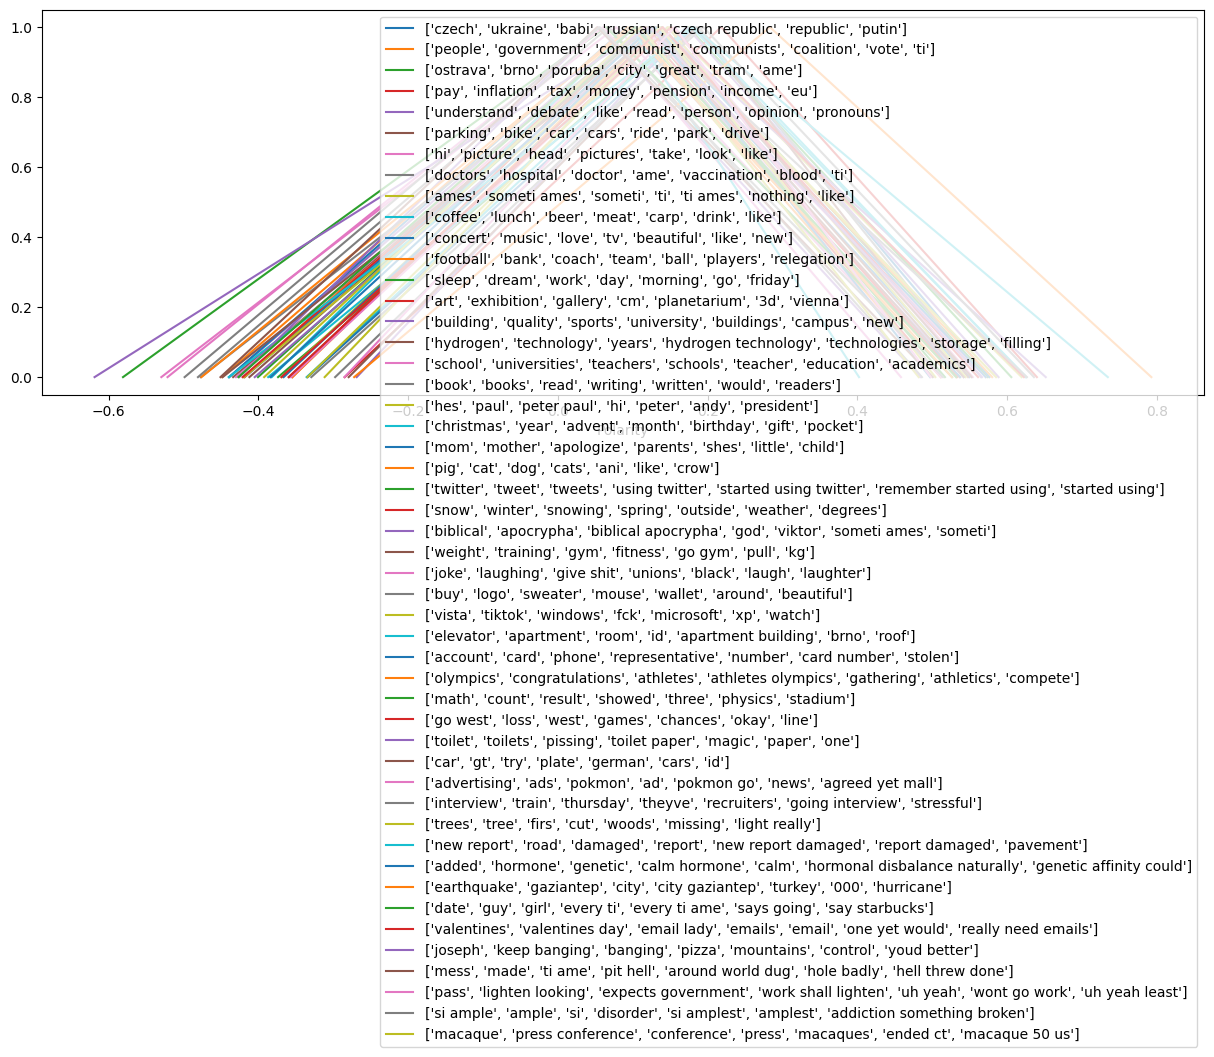

In [18]:
plt.figure(figsize=(15, 5))
plt.xlabel('Polarity')
# plt.plot([-1, 0.75, 1], [1, 0, 0], color='red', label='Negative opinion')
# plt.plot([-1, -0.32, 1], [0, 0, 1], color='green', label='Positive opinion')

topics_processed = []

for topic in topic_model.get_topics().items():
    if topic[0] == -1:
        continue
    #if topic[0] > 30:
    #    break
    core = mean_sentiments[topic[0]]
    support_left = core - semivariance_left[topic[0]] * 1.5
    support_right = core + semivariance_right[topic[0]] * 1.5
    con_pos = conformity_positive([support_left, core, support_right], -0.32, 1)
    con_neg = conformity_negative([support_left, core, support_right], 1, -0.75)
    topic_name = str([t[0] for t in topic[1][:7]])
    plt.plot([support_left, core, support_right], [0, 1, 0], label=topic_name)
    print(f'TOPIC: {topic_name}, CON.POS.: {con_pos:.2f}, CON.NEG.: {con_neg:.2f}')
    topics_processed.append({
        'name': topic_name,
        'sent_mean': core,
        'support_left': support_left,
        'support_right': support_right,
        'con_pos': con_pos,
        'con_neg': con_neg
    })

topics_processed = pd.DataFrame(topics_processed)

plt.legend()
plt.show()


### Exploration of topics

In [19]:
topics_processed['controversy'] = topics_processed.con_pos + topics_processed.support_left
con_min = min(topics_processed.con_pos.min(), topics_processed.con_neg.min())
con_max = max(topics_processed.con_pos.max(), topics_processed.con_neg.max())
topics_processed['con_pos'] = (topics_processed.con_pos - con_min) / (con_max - con_min)
topics_processed['con_neg'] = (topics_processed.con_neg - con_min) / (con_max - con_min)
topics_processed.sort_values(by='sent_mean', ascending=False)


,name,sent_mean,support_left,support_right,con_pos,con_neg,controversy
31,"['olympics', 'congratulations', 'athletes', 'a...",0.283000,-0.272133,0.792604,1.000000,0.000000,0.335979
13,"['art', 'exhibition', 'gallery', 'cm', 'planet...",0.218133,-0.284806,0.639701,0.653566,0.096528,0.266250
27,"['buy', 'logo', 'sweater', 'mouse', 'wallet', ...",0.194063,-0.329403,0.635808,0.601829,0.190454,0.213132
17,"['book', 'books', 'read', 'writing', 'written'...",0.188597,-0.297566,0.565174,0.475573,0.152098,0.224175
15,"['hydrogen', 'technology', 'years', 'hydrogen ...",0.185730,-0.279505,0.547849,0.440265,0.129467,0.236420
10,"['concert', 'music', 'love', 'tv', 'beautiful'...",0.182779,-0.334294,0.576301,0.483674,0.211683,0.188781
19,"['christmas', 'year', 'advent', 'month', 'birt...",0.181244,-0.387007,0.734425,0.725518,0.285635,0.175899
29,"['elevator', 'apartment', 'room', 'id', 'apart...",0.178514,-0.439653,0.624475,0.554999,0.357846,0.095169
12,"['sleep', 'dream', 'work', 'day', 'morning', '...",0.174315,-0.373795,0.605515,0.516632,0.276828,0.154708
14,"['building', 'quality', 'sports', 'university'...",0.172142,-0.268788,0.588530,0.484612,0.131070,0.254441
